<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4807 entries, 0 to 4806
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      4807 non-null   datetime64[ns]
 1   y       4807 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 75.2 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4807 entries, 0 to 4806
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      4807 non-null   datetime64[ns]
 1   y       4807 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 75.2 KB


C:\Users\rafae\AppData\Local\Temp\ipykernel_19176\1263838836.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wti_oil_df['ds'] = pd.to_datetime(wti_oil_df['ds'])


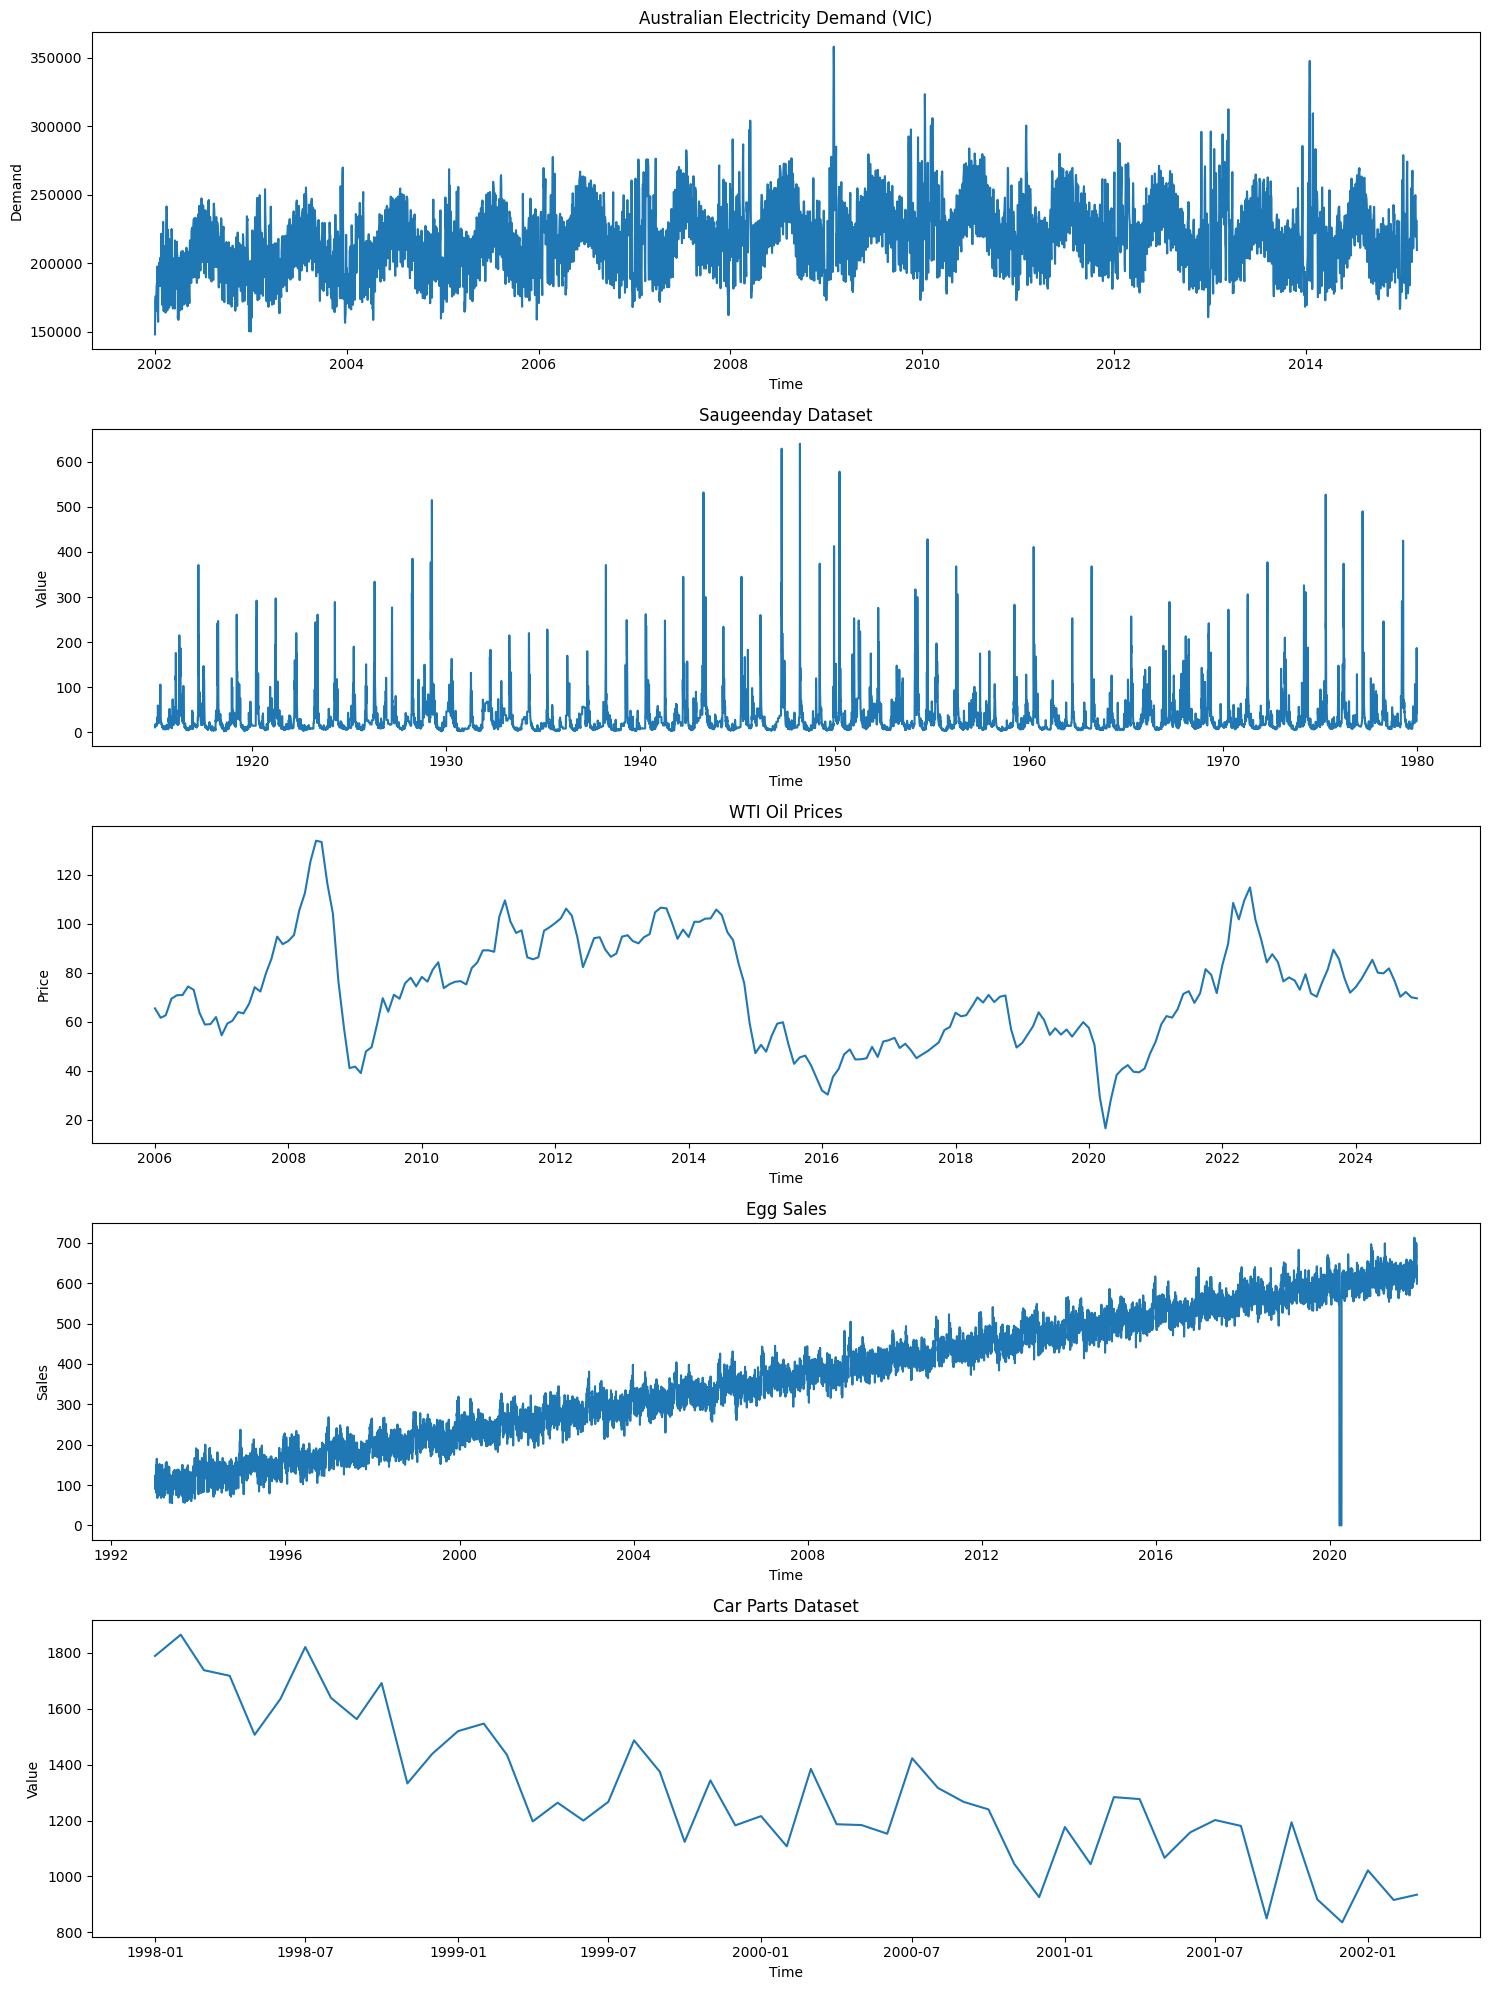

In [2]:
%run "datagetter.ipynb"
%run "basic_functions.ipynb"

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric

def calc_forecast_metrics(y_true, y_pred):
    """Return MAE, MAPE, RMSE in a dictionary for model evaluation."""
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    mask = y_true != 0
    mae = np.mean(np.abs(y_true - y_pred))
    mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100 if np.any(mask) else np.nan
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    return {"MAE": mae, "MAPE": mape, "RMSE": rmse}

def prophet_forecast_and_cv(
    train_df, 
    test_df, 
    alpha=0.05, 
    figsize=(14, 6),
    cv_initial='400 days', 
    cv_period='60 days', 
    cv_horizon='90 days',
    cv_metric='mape',
    plot_cv=True
):
    """
    Fit Prophet model, plot, print metrics, run cross-validation, and print/plot CV results.
    Returns: model, forecast_test, eval_metrics, df_cv, df_p
    """
    # Prophet expects 'ds' (datetime) and 'y' (float) columns
    m = Prophet(interval_width=1-alpha)
    m.fit(train_df)
    future = pd.concat([train_df[['ds']], test_df[['ds']]], ignore_index=True)
    forecast = m.predict(future)
    
    # Only forecast for the test period
    forecast_test = forecast[forecast['ds'].isin(test_df['ds'])].copy()
    forecast_test = forecast_test[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
    test_df_sorted = test_df.sort_values('ds').reset_index(drop=True)
    forecast_test_sorted = forecast_test.sort_values('ds').reset_index(drop=True)

    # Plot
    plt.figure(figsize=figsize)
    plt.plot(train_df['ds'], train_df['y'], label='Training Data', color='blue')
    plt.plot(test_df['ds'], test_df['y'], label='Test Data', color='green')
    plt.plot(forecast_test['ds'], forecast_test['yhat'], label='Prophet Forecast', color='darkorange')
    plt.fill_between(forecast_test['ds'],
                     forecast_test['yhat_lower'],
                     forecast_test['yhat_upper'],
                     color='orange', alpha=0.2, label=f'{int((1-alpha)*100)}% CI')
    split_date = test_df['ds'].iloc[0]
    plt.axvline(split_date, color='tab:red', linestyle='--', label='Train/Test Split')
    plt.title('Prophet Forecast')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # ---- METRICS ----
    eval_df = test_df_sorted.merge(forecast_test_sorted[['ds', 'yhat']], on='ds', how='left')
    metrics = calc_forecast_metrics(eval_df['y'].values, eval_df['yhat'].values)
    print(f"MAE: {metrics['MAE']:.2f}")
    print(f"MAPE: {metrics['MAPE']:.2f}%")
    print(f"RMSE: {metrics['RMSE']:.2f}")

    # ---- CROSS-VALIDATION ----
    print("\nRunning Prophet cross-validation...")
    try:
        df_cv = cross_validation(m, initial=cv_initial, period=cv_period, horizon=cv_horizon, parallel="processes")
        df_p = performance_metrics(df_cv)
        print(df_p[['horizon', 'mae', 'mape', 'rmse']].head())

        if plot_cv:
            plot_cross_validation_metric(df_cv, metric=cv_metric)
            plt.tight_layout()
            plt.show()
    except Exception as e:
        print(f"Cross-validation failed: {e}")
        df_cv, df_p = None, None

    return m, forecast_test, metrics, df_cv, df_p


18:58:42 - cmdstanpy - INFO - Chain [1] start processing
18:58:42 - cmdstanpy - INFO - Chain [1] done processing


==== WTI Oil ====


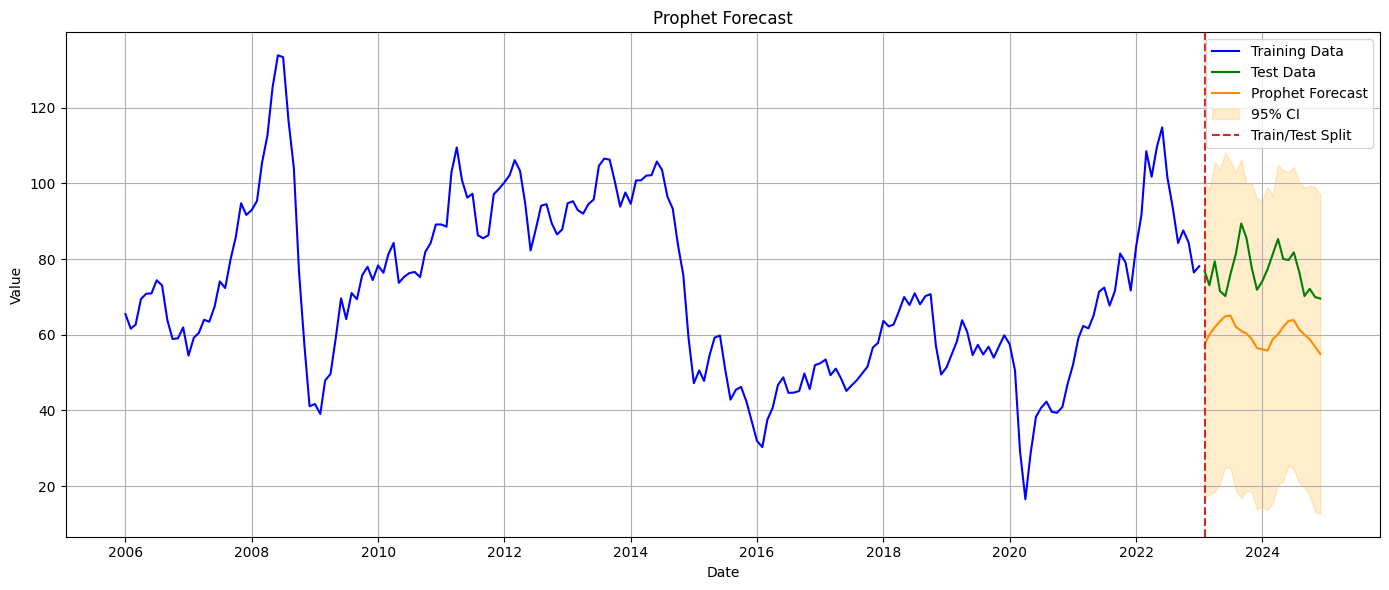

MAE: 16.83
MAPE: 21.54%
RMSE: 17.70

Running Prophet cross-validation...
  horizon        mae      mape       rmse
0 10 days  16.872697  0.217485  31.860917
1 11 days  18.109957  0.226288  33.427687
2 12 days  19.059669  0.226338  35.033945
3 13 days  17.598564  0.203642  34.394708
4 14 days  17.570406  0.216204  34.374484


c:\Users\rafae\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\plot.py:547: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])
c:\Users\rafae\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\plot.py:548: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])


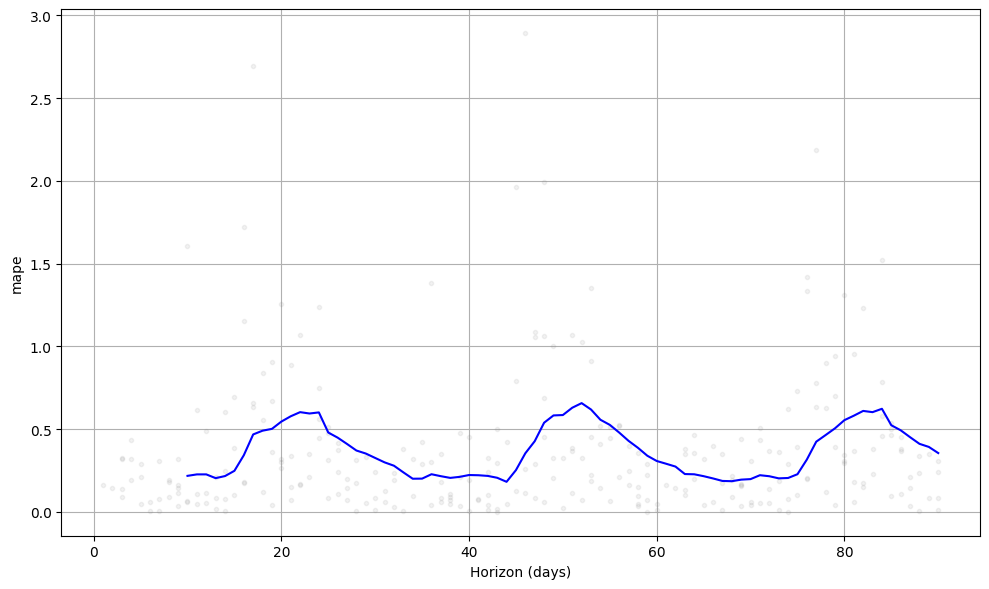

==== Saugeen River ====


18:59:03 - cmdstanpy - INFO - Chain [1] start processing
18:59:10 - cmdstanpy - INFO - Chain [1] done processing


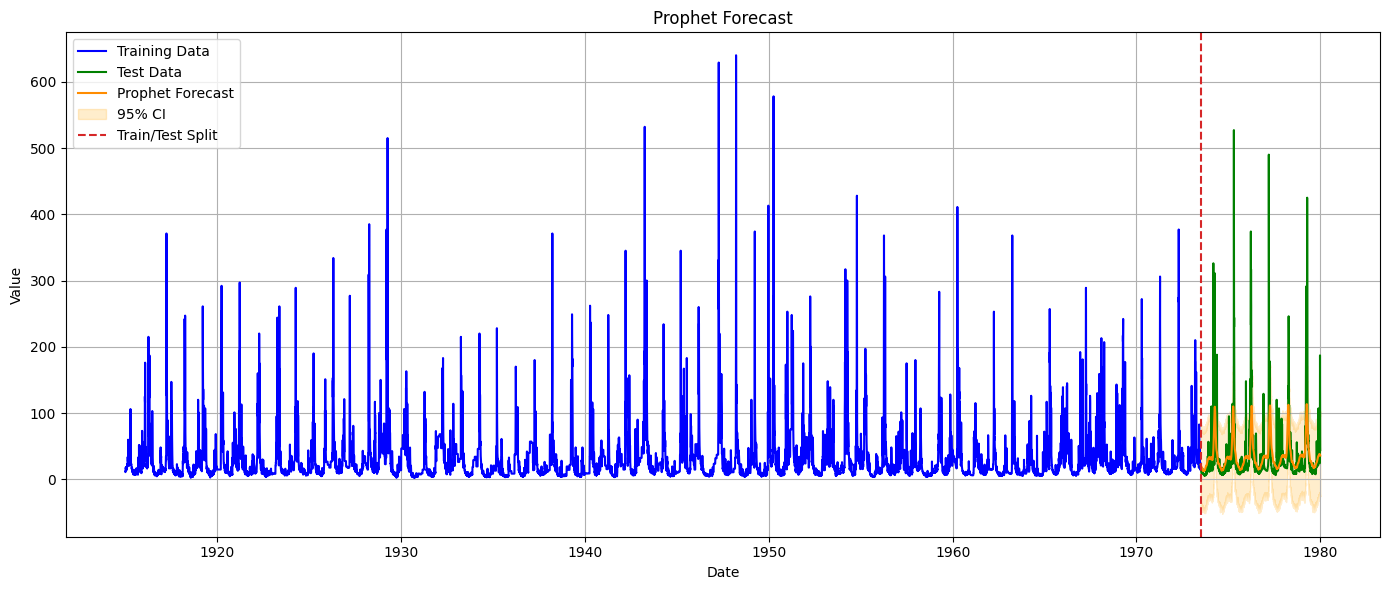

MAE: 19.03
MAPE: 74.47%
RMSE: 36.49

Running Prophet cross-validation...
  horizon        mae      mape       rmse
0  9 days  18.144486  0.792716  34.008928
1 10 days  17.965522  0.798617  33.322028
2 11 days  17.616817  0.808582  32.175116
3 12 days  17.063874  0.808463  29.737037
4 13 days  16.748638  0.810767  28.897288


c:\Users\rafae\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\plot.py:547: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])
c:\Users\rafae\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\plot.py:548: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])


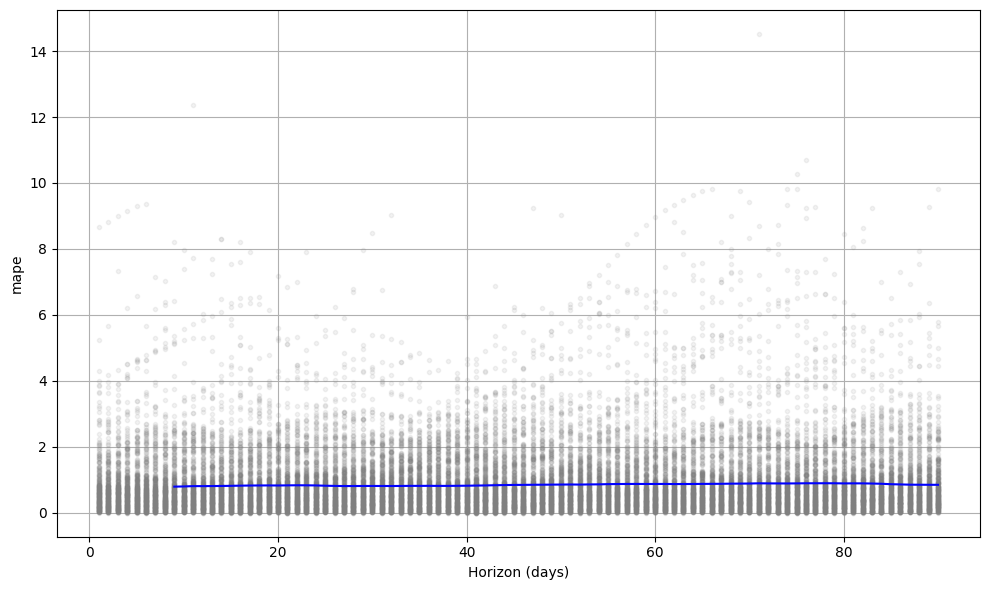

==== Egg Sales ====


19:15:16 - cmdstanpy - INFO - Chain [1] start processing
19:15:17 - cmdstanpy - INFO - Chain [1] done processing


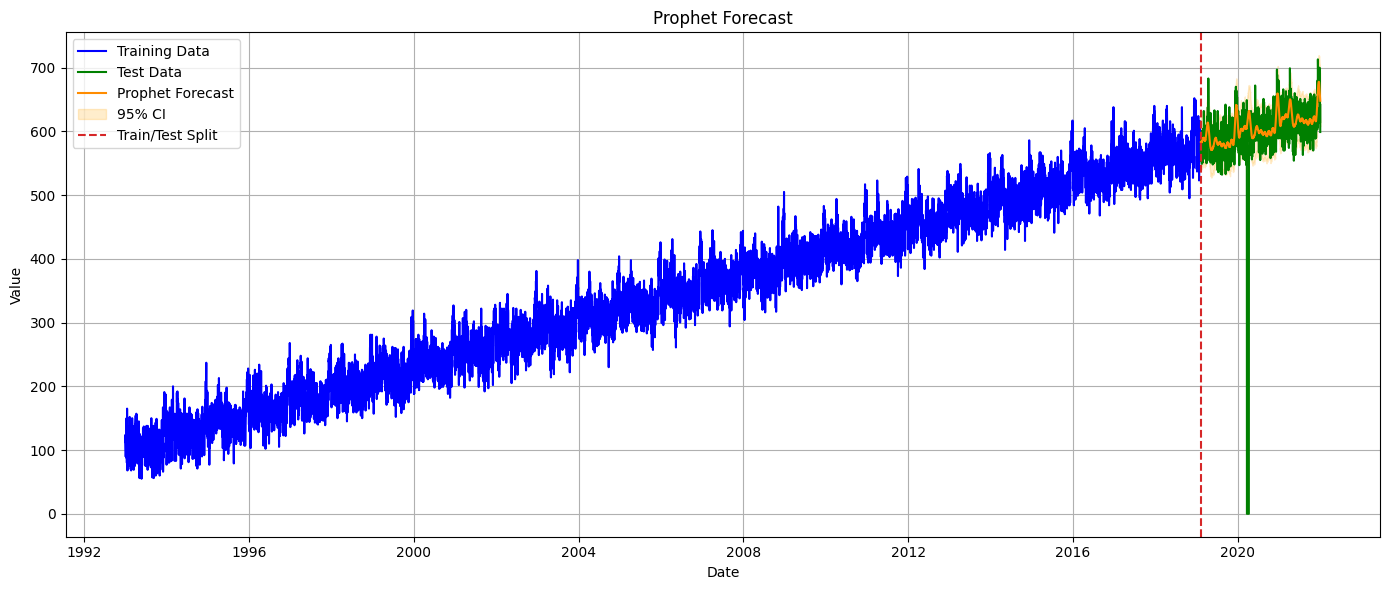

MAE: 27.72
MAPE: 2.90%
RMSE: 83.75

Running Prophet cross-validation...
  horizon        mae      mape       rmse
0  9 days  16.867012  0.059411  20.998110
1 10 days  16.548420  0.058161  20.772443
2 11 days  16.113410  0.056303  20.363892
3 12 days  16.384678  0.056587  20.641377
4 13 days  16.546518  0.057461  20.906109


c:\Users\rafae\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\plot.py:547: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])
c:\Users\rafae\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\plot.py:548: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])


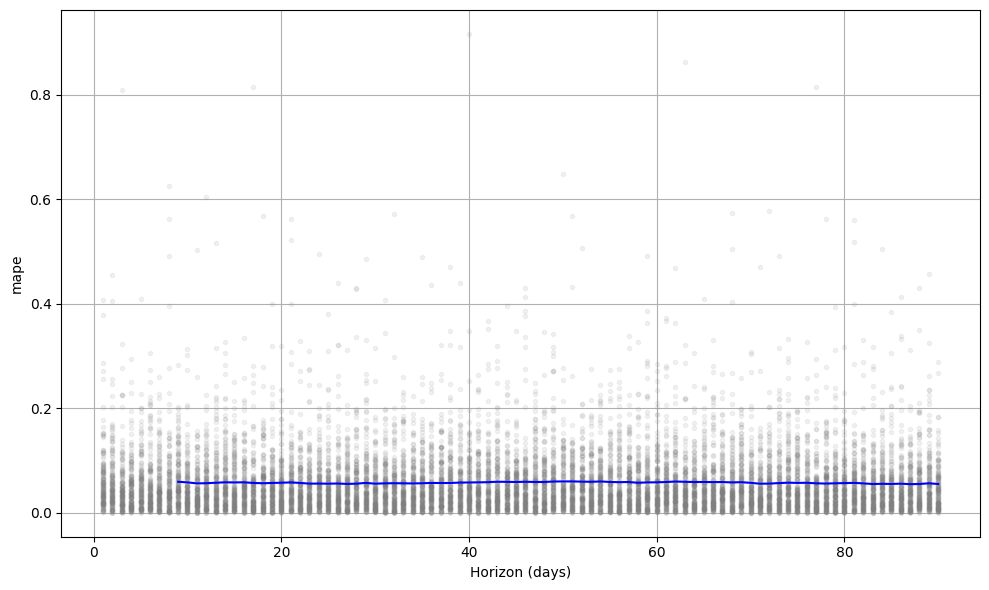

==== Australian Electricity Demand ====


19:16:17 - cmdstanpy - INFO - Chain [1] start processing
19:16:18 - cmdstanpy - INFO - Chain [1] done processing


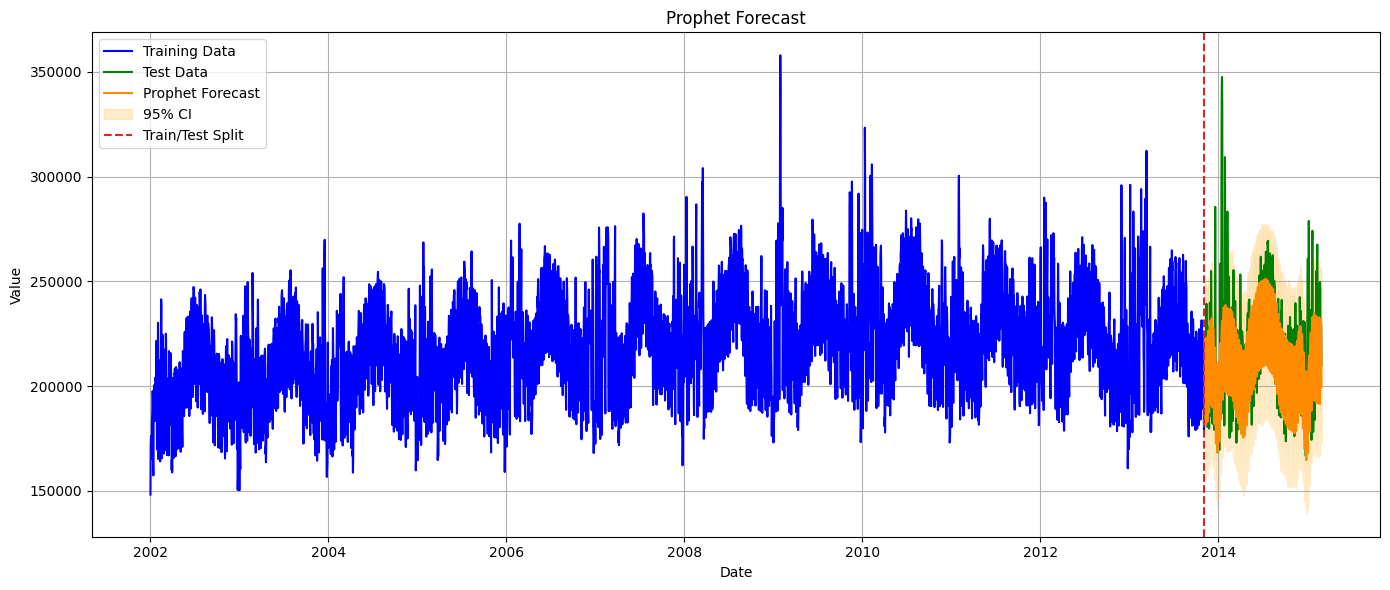

MAE: 11946.54
MAPE: 5.26%
RMSE: 18847.70

Running Prophet cross-validation...
  horizon           mae      mape          rmse
0  9 days   9639.968784  0.043477  14199.151667
1 10 days   9795.921948  0.044021  14267.631519
2 11 days  10194.769950  0.045502  14739.748444
3 12 days  10651.383941  0.047137  15532.412019
4 13 days  10705.396906  0.047069  15733.899915


c:\Users\rafae\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\plot.py:547: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])
c:\Users\rafae\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\plot.py:548: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])


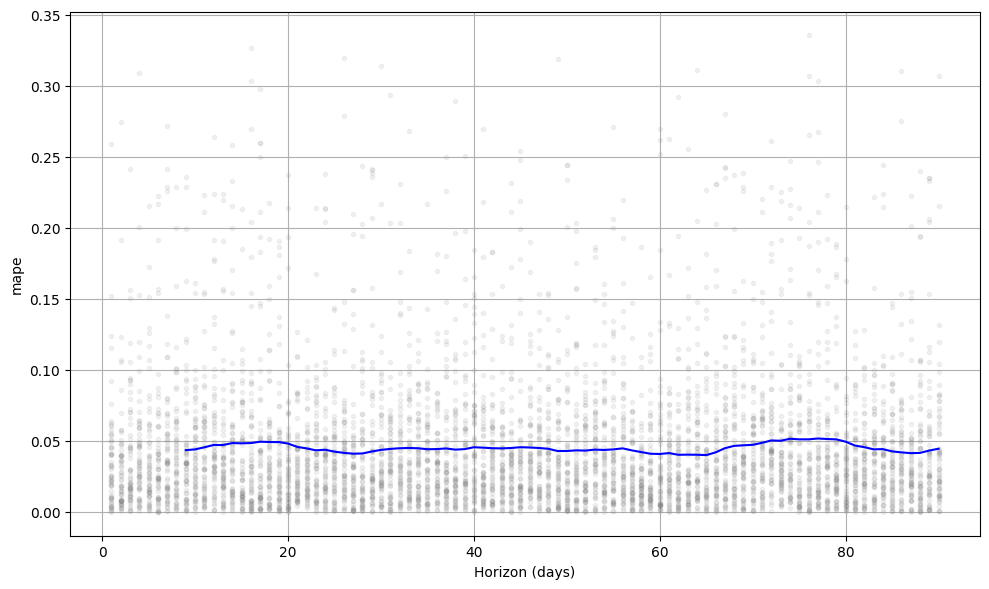

19:16:38 - cmdstanpy - INFO - Chain [1] start processing


==== Car Parts ====


19:16:39 - cmdstanpy - INFO - Chain [1] done processing


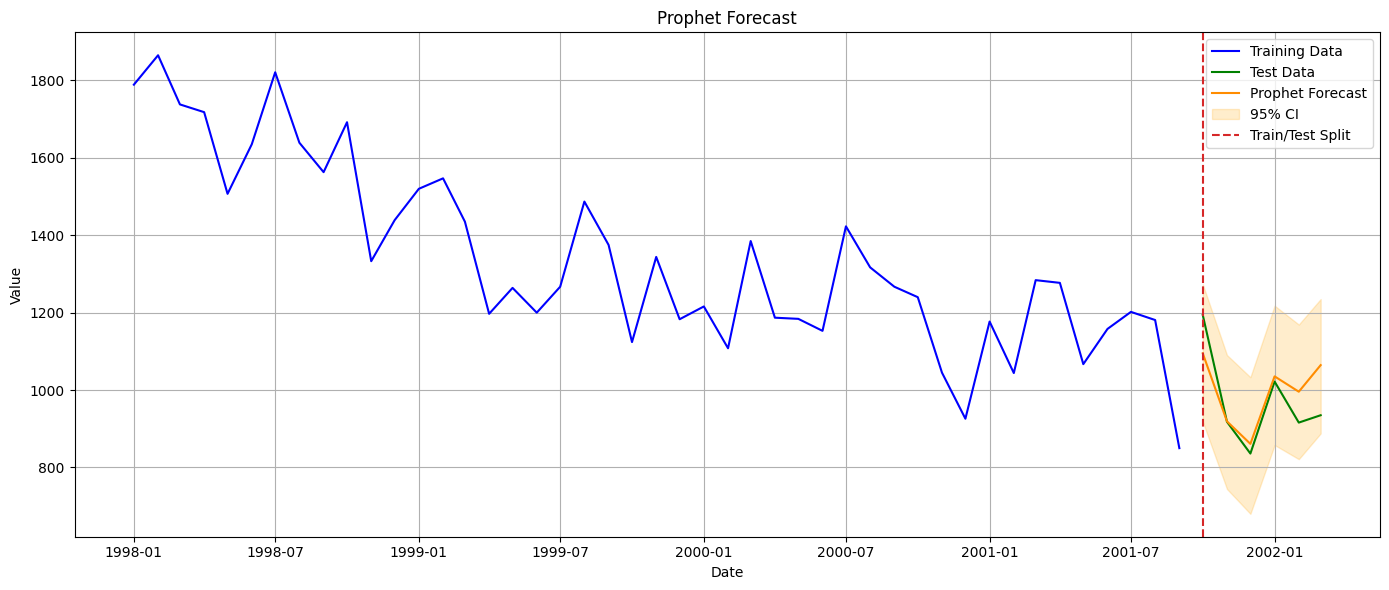

MAE: 58.01
MAPE: 5.88%
RMSE: 75.00

Running Prophet cross-validation...
  horizon         mae      mape        rmse
0 19 days  487.338473  0.361368  707.137571
1 20 days  622.603918  0.463229  775.330541
2 21 days  651.568103  0.480632  785.210311
3 22 days  509.597317  0.400571  558.057942
4 23 days  371.805013  0.297086  458.081849


c:\Users\rafae\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\plot.py:547: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])
c:\Users\rafae\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\plot.py:548: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])


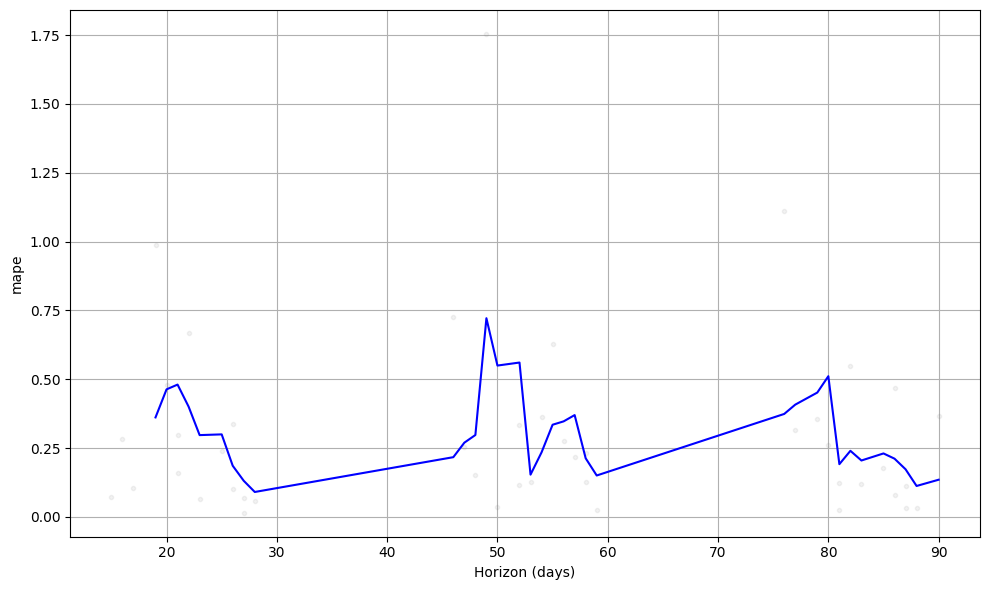

In [11]:
results = {}
for name, df in zip(dataset_names, datasets):
    train_df, test_df = split_train_test(df, test_size=0.1)
    print(f"==== {name} ====")
    model, forecast, metrics, df_cv, df_p = prophet_forecast_and_cv(
        train_df, test_df,
        cv_initial='400 days',   # adjust for dataset size!
        cv_period='60 days',
        cv_horizon='90 days',
        cv_metric='mape',
        plot_cv=True
    )
    results[name] = {
        "model": model, 
        "forecast": forecast, 
        "metrics": metrics, 
        "cv": df_cv, 
        "cv_metrics": df_p
    }
